## Department of Computer Science, University of York
### DATA: Introduction to Data Science

## Task 1: Domain Analysis  (5 marks)

Given the business domain and the data overview presented (in the assessment paper), provide a brief description of

* the business problem and its significance to the relevant sector;
* the link between the business problem and the field of data science;
* the main areas of investigation; and
* potential ideas and solutions.


**Word Limit:** 300 words

**Write your answer here (text cell(s) to be used, as appropriate)**

todo mentioned data science lifecycle

The questions at hand are of demographics, loan default prediction, and expansion area. Banks like this one make profit from interest on loans and credit cards[^1], so the objectives are to refuse loans that will default, give high-value customers reasons to continue doing business with the bank, and onboard new customers.

We can leverage data science to load and quickly perform operations on huge amounts of figures and categorical data (e.g. over 100,000 rows of transactions), creating descriptions and visualisations of the data that people can understand. We can inform decision making by using techniques from statistics to summarise business operations and make predictions of the outcomes of providing credit.

The investigations I have chosen to carry out will be the coverage of the customer base over different cities, and the way a customer's characteristics and prior usage of services relate to credit outcomes. Proposals will include strategies for predicting whether to authorise products, how to identify customers to target with perks, and potential geographic areas of expansion to focus on, using models like logistic regression and visualisation like bar charts.

[^1]: https://www.investopedia.com/terms/c/commercialbank.asp

In [ ]:
### Write your answer here (code cell(s) to be used, as appropriate)



----
----


## Task 2: Database Design (25 marks)


Having understood the business domain, present a conceptual design in the form of an entity-relationship (ER) model that would be helpful in creating a database for the bank.

The bank data currently exists in the form of a csv file called *BankRecords.csv*, provided on VLE (path given in page 5, assessment paper). This file has all the existing records. The table available in the csv file is unnormalised. The information about its different columns is given in Tables 1 and 2 (in the assessment paper).

Following the standard principles of database normalisation, normalise the given table (*BankRecords.csv*) to a database schema that has minimum redundancies. Then, using the designed schema, create an SQLite database.

Your answer should include the SQL statements needed to accomplish this step. Your submission should also include the created SQLite database file.

Your answer should clearly cover the following:
* Any assumptions you are making about the given scenario;
* The designated keys, existing relationships, and identified functional dependencies;
* The steps followed and justifications for the decisions made.

**World Limit**: 500 words. This limit applies only to the explanations. There is no limit on any associated code/SQL statements or figures.

**Write your answer here (text cell(s) to be used, as appropriate)**

### Normal form

The data is already in first normal form as there are no composite values, so we can continue to 2NF.

This table is clearly not in second normal form. Loan date is dependent on loan ID, name is dependent on client ID, etc. etc. There are a bunch of values that should be primary keys all in the same table. I split up the dataset into eight separate tables intuitively based on the "Data Overview" and "Description of columns" from the specification. Each unique ID gets its own table.

Now in 2NF, I noticed noticed a transitive dependency - I had included dispID, clientID, and accountID together in their relevant tables. I realised clientID and accountID are both just dependent on dispID. Therefore I removed them from all the tables except Dispositon. Finally, we are in third normal form and finished.

I briefly thought there was a transitive dependency from "region" to "noAreas" because the data overview said noAreas was the number of *cities* in the *region*, and was repeated for each *city*, but the inconsistent noAreas for each region and the mismatch of actual city count implies this is an error in the data overview.

Reference:
- DATA-Lecture4-DatabaseNormalisationAndSQL.pdf
- https://en.wikipedia.org/wiki/Database_normalization

### ERM
For the ERM diagram, see `DATA Essay.jpg`.

<img src="DATA Essay.jpg" alt="ERM Diagram" width=425>

Reference:
- DATA-Lecture3-RelationalDatabases.pdf
- DATA-Practical3Part2 - Mapping ER model to tables - Solution.pdf
- https://en.wikipedia.org/wiki/Entity%E2%80%93relationship_model

In [1]:
import sqlite3
from pathlib import Path

In [2]:
### Write your answer here (code cell(s) to be used, as appropriate)

# the following classifier fields could be made integers:
#   Account
#     statementFrequency
#   Loan
#     loanStatus
#   StandingOrder
#     NOT paymentType
#   BankTransaction
#     transType
#     operation
#     NOT transDetail
#   Disposition
#     dispType
#   CreditCard
#     cardType

sql_script_path = Path("create_db.sql")
sqlf = Path("BankRecords.db")


def create_db():
    sql_create = sql_script_path.read_text(encoding="utf-8")
    
    print("Deleting database")
    try:
        sqlf.unlink()
    except FileNotFoundError:
        print("Database didn't exist")
    else:
        print("Deleted database")
    
    print("Creating database")
    con = sqlite3.connect(sqlf)
    with con:
        con.executescript(sql_create)
    con.close()
    print("Done")


create_db()

Deleting database
Deleted database
Creating database
Done


In [3]:
# this should be included in the notebook for submission
# I use a separate file for syntax highlighting and stuff
print(sql_script_path.read_text(encoding="utf-8"))

-- database has been tested with STRICT and check constrints,
-- so they can be disabled now for speed and compatability
PRAGMA ignore_check_constraints = true;
CREATE TABLE Account (
    accountID INTEGER PRIMARY KEY,
    statementFrequency TEXT NOT NULL,  -- frequency
    creationDate TEXT NOT NULL,
    CHECK (statementFrequency IN ('Monthly', 'Weekly', 'Per transaction'))
);
CREATE TABLE Loan (
    loanID INTEGER PRIMARY KEY,
    dispID INTEGER NOT NULL,
    loanDate TEXT NOT NULL,
    loanAmount INTEGER NOT NULL,
    loanDuration INTEGER NOT NULL,
    loanPayments INTEGER NOT NULL,
    loanStatus TEXT NOT NULL,
    FOREIGN KEY (dispID) REFERENCES Disposition(dispID),
    CHECK (loanStatus in ('A', 'B', 'C', 'D'))
);
CREATE TABLE StandingOrder (
    orderID INTEGER PRIMARY KEY,
    dispID INTEGER NOT NULL,
    bankTo TEXT NOT NULL,
    accountTo INTEGER NOT NULL,
    orderAmount REAL NOT NULL,
    paymentType TEXT,
    FOREIGN KEY (dispID) REFERENCES Disposition(dispID)
);
CREATE TA

In [4]:
import pandas as pd

In [5]:
%%time

# load dataframe
DATE_FORMAT_CSV = "%y%m%d"

csvf = Path("BankRecords.csv")

print("Loading csv")

# could manually convert to datetime after reading
# to set the unit to something better for dates than ns
# but this is fine
date_columns = [
    "creation_date",
    "loan_date",
    "trans_date",
    "card_issued",
]
date_formats = {c: DATE_FORMAT_CSV for c in date_columns}
date_formats["card_issued"] = f"{DATE_FORMAT_CSV} 00:00:00"  # they lied about this one

df = pd.read_csv(
    csvf,
    parse_dates=date_columns,
    date_format=date_formats,
    low_memory=False,
)

Loading csv
CPU times: user 6.55 s, sys: 8.5 s, total: 15.1 s
Wall time: 15.8 s


In [6]:
df.head()

,account_id,frequency,creation_date,loan_id,loan_date,loan_amount,loan_duration,loan_payments,loan_status,order_id,...,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16
0,1,Monthly,1995-03-24,NaN,NaT,NaN,NaN,NaN,NaN,29401.0,...,2,1,4,65.3,8968,2.83,3.35,131,1740.0,1910
1,1,Monthly,1995-03-24,NaN,NaT,NaN,NaN,NaN,NaN,29401.0,...,2,1,4,65.3,8968,2.83,3.35,131,1740.0,1910
2,1,Monthly,1995-03-24,NaN,NaT,NaN,NaN,NaN,NaN,29401.0,...,2,1,4,65.3,8968,2.83,3.35,131,1740.0,1910
3,1,Monthly,1995-03-24,NaN,NaT,NaN,NaN,NaN,NaN,29401.0,...,2,1,4,65.3,8968,2.83,3.35,131,1740.0,1910
4,1,Monthly,1995-03-24,NaN,NaT,NaN,NaN,NaN,NaN,29401.0,...,2,1,4,65.3,8968,2.83,3.35,131,1740.0,1910


In [7]:
# note that some columns we would expect to be int are float instead
# because int can't be NaN but float can
print(df.shape)
print(df.dtypes)
df.columns

(2243458, 46)
account_id                  int64
frequency                  object
creation_date      datetime64[ns]
loan_id                   float64
loan_date          datetime64[ns]
loan_amount               float64
loan_duration             float64
loan_payments             float64
loan_status                object
order_id                  float64
bank_to                    object
account_to                float64
order_amount              float64
payment_type               object
trans_id                    int64
trans_date         datetime64[ns]
trans_type                 object
operation                  object
trans_amount              float64
balance                   float64
trans_detail               object
partner_bank               object
partner_account           float64
disp_id                     int64
client_id                   int64
disp_type                  object
card_id                   float64
card_type                  object
card_issued        datetime64[ns]


Index(['account_id', 'frequency', 'creation_date', 'loan_id', 'loan_date',
       'loan_amount', 'loan_duration', 'loan_payments', 'loan_status',
       'order_id', 'bank_to', 'account_to', 'order_amount', 'payment_type',
       'trans_id', 'trans_date', 'trans_type', 'operation', 'trans_amount',
       'balance', 'trans_detail', 'partner_bank', 'partner_account', 'disp_id',
       'client_id', 'disp_type', 'card_id', 'card_type', 'card_issued',
       'birth_number', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9',
       'a10', 'a11', 'a12', 'a13', 'a14', 'a15', 'a16'],
      dtype='object')

In [8]:
x = "loan_amount"
print(df[(df[x] % 1 != 0) & df[x].notna()])

Empty DataFrame
Columns: [account_id, frequency, creation_date, loan_id, loan_date, loan_amount, loan_duration, loan_payments, loan_status, order_id, bank_to, account_to, order_amount, payment_type, trans_id, trans_date, trans_type, operation, trans_amount, balance, trans_detail, partner_bank, partner_account, disp_id, client_id, disp_type, card_id, card_type, card_issued, birth_number, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11, a12, a13, a14, a15, a16]
Index: []

[0 rows x 46 columns]


In [9]:
pd.set_option("display.max_columns", 100)
print(df[df["trans_id"].notna() & df["card_id"].notna()].tail())

         account_id frequency creation_date  loan_id  loan_date  loan_amount  \
2241480       11359   Monthly    1994-10-01   7305.0 1996-08-06      54024.0   
2241481       11359   Monthly    1994-10-01   7305.0 1996-08-06      54024.0   
2241482       11359   Monthly    1994-10-01   7305.0 1996-08-06      54024.0   
2241483       11359   Monthly    1994-10-01   7305.0 1996-08-06      54024.0   
2241484       11359   Monthly    1994-10-01   7305.0 1996-08-06      54024.0   

         loan_duration  loan_payments loan_status  order_id bank_to  \
2241480           12.0         4502.0           A   46329.0      OP   
2241481           12.0         4502.0           A   46329.0      OP   
2241482           12.0         4502.0           A   46329.0      OP   
2241483           12.0         4502.0           A   46329.0      OP   
2241484           12.0         4502.0           A   46329.0      OP   

         account_to  order_amount payment_type  trans_id trans_date  \
2241480  33080721.0  

In [10]:
# since a 2-digit year is ambiguous we have to check this works fine
# python's datetime pivot year is 1970
# so we can verify all the years are between 70 and 99 like so:
for c in date_columns:
    print(c, sum(df[c] > pd.Timestamp(year=2000, month=1, day=1)))

# therefore, in the special parsing we do for birth_number
# we can assume all dates lie in the decade 1900

creation_date 0
loan_date 0
trans_date 0
card_issued 0


In [11]:
%%time

# ISO 8601 date
# https://www.sqlite.org/lang_datefunc.html
DATE_FORMAT_SQL = "%Y-%m-%d"


# reset db for testing
create_db()


def filter_df(columns: list[str]):
    return df.filter(columns).groupby(columns[0]).first()


print("Inserting data")
con = sqlite3.connect(sqlf)
cur = con.cursor()

accounts = filter_df(
    ["account_id", "frequency", "creation_date"]
)
# no inplace option for this 3':
accounts["creation_date"] = accounts["creation_date"].dt.strftime(DATE_FORMAT_SQL)
cur.executemany(
    "INSERT INTO Account VALUES (?, ?, ?);",
    accounts.itertuples()
)

loans = filter_df(
    ["loan_id", "disp_id", "loan_date", "loan_amount", "loan_duration", "loan_payments", "loan_status"]
)
loans["loan_date"] = loans["loan_date"].dt.strftime(DATE_FORMAT_SQL)
cur.executemany(
    "INSERT INTO Loan VALUES (?, ?, ?, ?, ?, ?, ?);",
    loans.itertuples()
)

standing_orders = filter_df(
    ["order_id", "disp_id", "bank_to", "account_to", "order_amount", "payment_type"]
)
cur.executemany(
    "INSERT INTO StandingOrder VALUES (?, ?, ?, ?, ?, ?);",
    standing_orders.itertuples()
)

transactions = filter_df(
    [
        "trans_id", "disp_id",
        "trans_date", "trans_type", "operation", "trans_amount", "balance", "trans_detail", "partner_bank", "partner_account",
    ]
)
transactions["trans_date"] = transactions["trans_date"].dt.strftime(DATE_FORMAT_SQL)
cur.executemany(
    "INSERT INTO BankTransaction VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?);",
    transactions.itertuples()
)

clients = filter_df(
    ["client_id", "a1", "birth_number"]
)
# separating birth number into relevant columns
# could also do this as string operations
# bool mask of all rows with MM+50
clients["gender"] = ((clients["birth_number"] // 100) % 100) > 12
# remove offset
# 100(x + 50) = 100x + 5000
clients.loc[clients["gender"], "birth_number"] -= 5000
# parse date
clients["birth_number"] += 19000000  # see above cell
clients["birth_number"] = pd.to_datetime(clients["birth_number"], format="%Y%m%d")
clients["birth_number"] = clients["birth_number"].dt.strftime(DATE_FORMAT_SQL)
cur.executemany(
    "INSERT INTO Client VALUES (?, ?, ?, ?);",
    clients.itertuples()
)

dispositions = filter_df(
    ["disp_id", "account_id", "client_id", "disp_type"]
)
# dispo elysium
cur.executemany(
    "INSERT INTO Disposition VALUES (?, ?, ?, ?);",
    dispositions.itertuples()
)

credit_cars = filter_df(
    ["card_id", "disp_id", "card_type", "card_issued"]
)
credit_cars["card_issued"] = credit_cars["card_issued"].dt.strftime(DATE_FORMAT_SQL)
cur.executemany(
    "INSERT INTO CreditCard VALUES (?, ?, ?, ?);",
    credit_cars.itertuples()
)

cities = filter_df(
    [f"a{i}" for i in range(1, 16+1)]
)
cur.executemany(
    "INSERT INTO City VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?);",
    cities.itertuples()
)

cur.close()
con.commit()
con.close()
print("Inserting data complete")

Deleting database
Deleted database
Creating database
Done
Inserting data
Inserting data complete
CPU times: user 9 s, sys: 308 ms, total: 9.31 s
Wall time: 9.5 s


----
----


## Task 3: Research Design (25 Marks)

Using the database designed in Task 2, design and implement **five** potential modelling solutions to achieve the aim of the Data Intelligence team. You need to provide clear justifications about the techniques selected in the context of the 'problem in hand'. Your design must consist of a combination of inferential statistics, supervised learning algorithms, and unsupervised learning algorithms, and include **at least one** of those techniques. Finally, your modelling solutions should be of sufficient complexity, combining information from multiple tables from the database built in Task 2, as appropriate. Your answer should clearly show the queries made to the database. If amendments are made to the database, the commands should be clearly included in your answer.

Your answer should clearly cover the following:
* Any assumptions you are making about the given scenario;
* Any data processing and data integrity steps you would undertake to make the data fit for purpose;
* Which technique(s) you would apply for each solution and why;
* An evaluation of the techniques applied in terms of the accuracy of their results (or any other suitable evaluation measure);
* Algorithmic parameters should be adequately stated and discussed;
* A discussion of ethical considerations arising from the solutions selected.

**World Limit**: 500 words. This limit applies only to the explanations. There is no limit on any associated code or figures.

**Write your answer here (text cell(s) to be used, as appropriate)**


### Demographic analysis

In [12]:
### Write your answer here (code cell(s) to be used, as appropriate)

con = sqlite3.connect(sqlf)
dfc = pd.read_sql_query("SELECT * FROM Client;", con, parse_dates=["birthDate"])
con.close()

dfc["birthDate"].describe()

count                             5369
mean     1953-09-12 09:32:21.143602176
min                1911-08-20 00:00:00
25%                1940-11-25 00:00:00
50%                1954-05-06 00:00:00
75%                1968-06-09 00:00:00
max                1987-09-27 00:00:00
Name: birthDate, dtype: object

In [13]:
import matplotlib.pyplot as plt

In [14]:
# calculate rough age in years

# none of the data is after 1999
# use the milennium as a reasonable point for analysis
y2k = pd.Timestamp(year=2000, month=1, day=1)
dfc["age"] =  y2k.year - dfc["birthDate"].dt.year
dfc["age"].describe()

count    5369.000000
mean       46.801639
std        17.282283
min        13.000000
25%        32.000000
50%        46.000000
75%        60.000000
max        89.000000
Name: age, dtype: float64

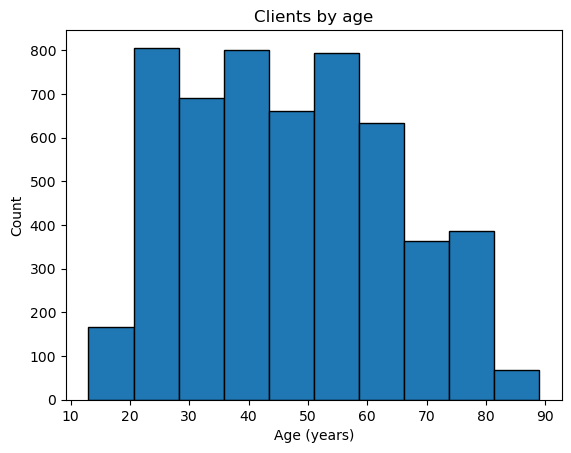

In [15]:
fig, ax = plt.subplots()
ax.hist(dfc["age"], bins=10, edgecolor="black")
ax.set_title("Clients by age")
ax.set_xlabel("Age (years)")
ax.set_ylabel("Count")
plt.show()

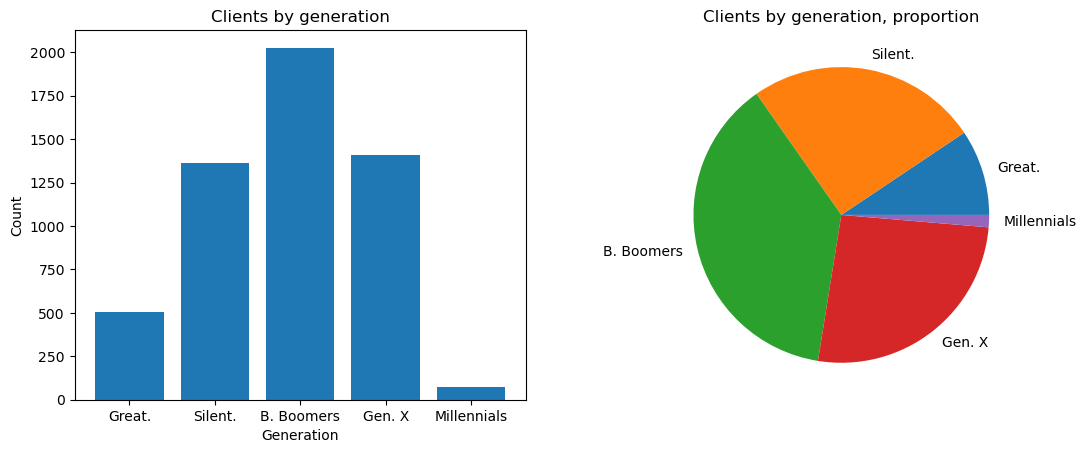

In [88]:
# https://en.wikipedia.org/wiki/Generation#Western_world
generations = {   
    1901: "Great.",
    1928: "Silent.",
    1946: "B. Boomers",
    1967: "Gen. X",
    1981: "Millennials",
    1997: "Gen. Z"
}

def get_generation(birth_year: int) -> str:
    year_after = max(y for y in generations.keys() if birth_year >= y)
    gen = generations[year_after]
    return gen

dfc["generation"] = dfc["birthDate"].dt.year.apply(get_generation)
bins = dfc.groupby("generation")["clientID"].count()
# order columns
labels = list(generations.values())
labels.pop()  # no gen.z in here
bins = bins[labels]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(fig.get_figwidth() * 2)

ax1.bar(bins.index, bins)
ax1.set_title("Clients by generation")
ax1.set_xlabel("Generation")
ax1.set_ylabel("Count")

ax2.pie(bins, labels=bins.index)
ax2.set_title("Clients by generation, proportion")

plt.show()

In [53]:
con = sqlite3.connect(sqlf)
# todo can write justificaiton of why owner

def client_action_count(table, column, col_as):
    query = "SELECT clientID, count({column}) as {col_as} FROM {table} JOIN Disposition ON {table}.dispID = Disposition.dispID WHERE Disposition.dispType = 'OWNER' GROUP BY clientID;"
    return pd.read_sql_query(
        query.format(table=table, column=column, col_as=col_as),
        con
    )

client_loancount = client_action_count("Loan", "loanID", "loanCount")
client_orderscount = client_action_count("StandingOrder", "orderID", "orderCount")
client_transcount = client_action_count("BankTransaction", "transID", "transCount")
client_cardcount = client_action_count("CreditCard", "cardID", "cardCount")
con.close()

dfccounts = dfc.copy()
for countdf in (client_loancount, client_orderscount, client_transcount, client_cardcount):
    dfccounts = dfccounts.merge(countdf, how="left", on="clientID")
dfccounts

,clientID,cityID,birthDate,gender,age,generation,loanCount,orderCount,transCount,cardCount
0,1,18,1970-12-13,1,30,Gen. X,NaN,1.0,239.0,NaN
1,2,1,1945-02-04,0,55,Silent.,1.0,2.0,478.0,NaN
2,3,1,1940-10-09,1,60,Silent.,NaN,NaN,NaN,NaN
3,4,5,1956-12-01,0,44,B. Boomers,NaN,3.0,117.0,NaN
4,5,5,1960-07-03,1,40,B. Boomers,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
5364,13955,1,1945-10-30,1,55,Silent.,1.0,2.0,304.0,NaN
5365,13956,1,1943-04-06,0,57,Silent.,NaN,NaN,NaN,NaN
5366,13968,61,1968-04-13,0,32,Gen. X,1.0,3.0,378.0,1.0
5367,13971,67,1962-10-19,1,38,B. Boomers,1.0,5.0,344.0,NaN


In [18]:
dfccounts.fillna(value=0, inplace=True)
dfccounts

,clientID,cityID,birthDate,gender,age,generation,loanCount,orderCount,transCount,cardCount
0,1,18,1970-12-13,1,30,Gen. X,0.0,1.0,239.0,0.0
1,2,1,1945-02-04,0,55,Silent.,1.0,2.0,478.0,0.0
2,3,1,1940-10-09,1,60,Silent.,0.0,0.0,0.0,0.0
3,4,5,1956-12-01,0,44,B. Boomers,0.0,3.0,117.0,0.0
4,5,5,1960-07-03,1,40,B. Boomers,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
5364,13955,1,1945-10-30,1,55,Silent.,1.0,2.0,304.0,0.0
5365,13956,1,1943-04-06,0,57,Silent.,0.0,0.0,0.0,0.0
5366,13968,61,1968-04-13,0,32,Gen. X,1.0,3.0,378.0,1.0
5367,13971,67,1962-10-19,1,38,B. Boomers,1.0,5.0,344.0,0.0


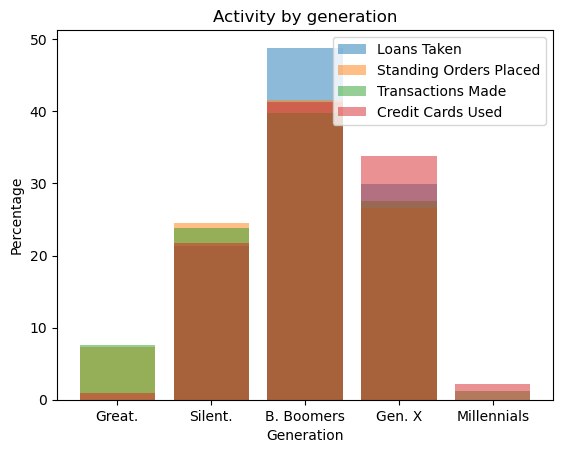

In [89]:
fig, ax = plt.subplots()

column_names = {
    "loanCount": "Loans Taken",
    "orderCount": "Standing Orders Placed",
    "transCount": "Transactions Made",
    "cardCount": "Credit Cards Used"
}

alpha = dict(alpha=0.5)

grouping = dfccounts.groupby("generation")
for col, col_name in column_names.items():
    bins = grouping[col].sum() / dfccounts[col].sum() * 100
    bins = bins[labels]  # order
    ax.bar(bins.index, bins, label=col_name, **alpha)

ax.set_title("Activity by generation")
ax.set_xlabel("Generation")
ax.set_ylabel("Percentage")
ax.legend()

plt.show()

In [64]:
# gonna use hbar for this one

con = sqlite3.connect(sqlf)
client_region = pd.read_sql_query(
    "SELECT clientID, region FROM Client JOIN City ON Client.cityID = City.cityID;",
    con
)
con.close()

dfr = dfccounts.merge(client_region, on="clientID")
dfr

,clientID,cityID,birthDate,gender,age,generation,loanCount,orderCount,transCount,cardCount,region
0,1,18,1970-12-13,1,30,Gen. X,NaN,1.0,239.0,NaN,West Yorkshire
1,2,1,1945-02-04,0,55,Silent.,1.0,2.0,478.0,NaN,Greater London
2,3,1,1940-10-09,1,60,Silent.,NaN,NaN,NaN,NaN,Greater London
3,4,5,1956-12-01,0,44,B. Boomers,NaN,3.0,117.0,NaN,Gloucestershire
4,5,5,1960-07-03,1,40,B. Boomers,NaN,NaN,NaN,NaN,Gloucestershire
...,...,...,...,...,...,...,...,...,...,...,...
5364,13955,1,1945-10-30,1,55,Silent.,1.0,2.0,304.0,NaN,Greater London
5365,13956,1,1943-04-06,0,57,Silent.,NaN,NaN,NaN,NaN,Greater London
5366,13968,61,1968-04-13,0,32,Gen. X,1.0,3.0,378.0,1.0,Wiltshire
5367,13971,67,1962-10-19,1,38,B. Boomers,1.0,5.0,344.0,NaN,North Yorkshire


In [84]:
con = sqlite3.connect(sqlf)
region_pops = pd.read_sql_query(
    "SELECT region, inhabitants AS population FROM City GROUP BY region;",
    con
)
con.close()

region_grouping = dfr.groupby("region")

region_pops = region_pops.merge(region_grouping["clientID"].count(), left_on="region", right_index=True)
region_pops.rename(columns={"clientID": "clientCount"}, inplace=True)

for col in column_names.keys():
    region_pops = region_pops.merge(region_grouping[col].sum(), left_on="region", right_index=True)

region_pops

,region,population,clientCount,loanCount,orderCount,transCount,cardCount
0,West Midlands,58400,51,2.0,60.0,8720.0,8.0
1,Aberdeen,122603,43,6.0,64.0,9154.0,6.0
2,Bedfordshire,124605,54,6.0,70.0,11559.0,3.0
3,Belfast,157042,63,11.0,86.0,12119.0,6.0
4,Berkshire,133777,126,12.0,153.0,24275.0,25.0
5,Bristol,177686,45,9.0,54.0,8889.0,11.0
6,Buckinghamshire,72541,54,7.0,68.0,10885.0,11.0
7,Cambridgeshire,112065,130,17.0,156.0,27358.0,18.0
8,Cardiff,161227,48,5.0,52.0,8477.0,7.0
9,Cheshire,67298,99,15.0,120.0,18943.0,25.0


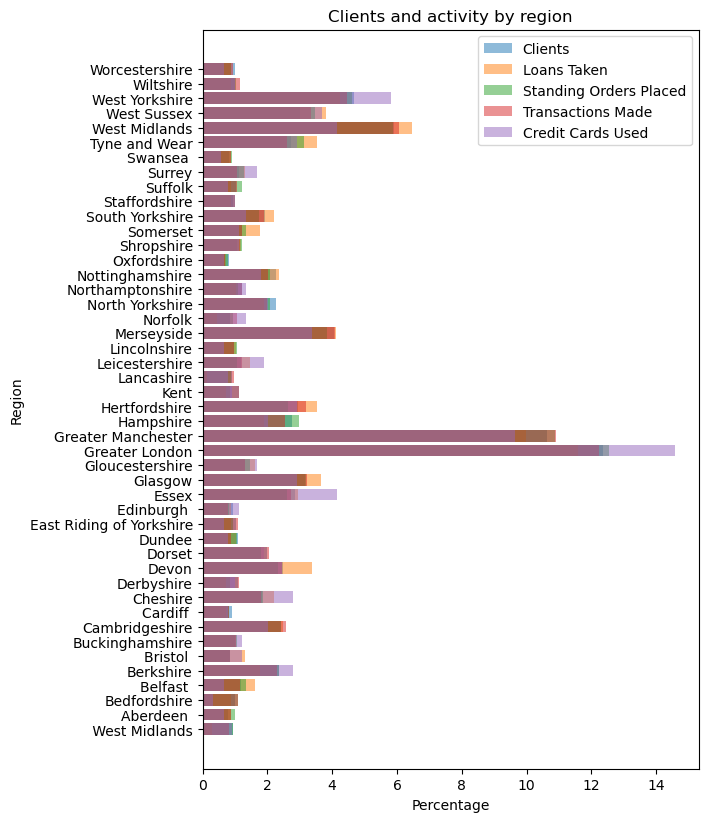

In [125]:
fig, ax = plt.subplots()
fig.set_figheight(fig.get_figheight() * 2)

column_names_wregion = dict(clientCount="Clients", **column_names)

region_bins = region_pops["region"]
y_pos = np.arange(len(region_bins))

for col, col_name in column_names_wregion.items():
    region_bin_values = region_pops[col] / region_pops[col].sum() * 100
    ax.barh(y_pos, region_bin_values, label=col_name, **alpha)

ax.set_title("Clients and activity by region")
ax.set_xlabel("Percentage")
ax.set_ylabel("Region")
ax.set_yticks(y_pos, labels=region_bins)
ax.legend()

plt.show()

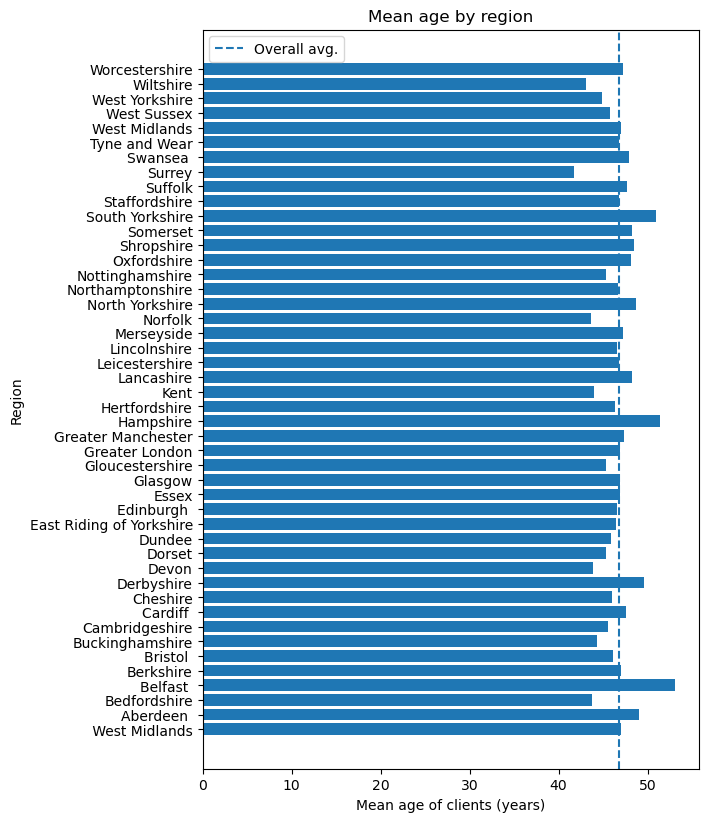

In [126]:
# finally, bring the two together
fig, ax = plt.subplots()
fig.set_figheight(fig.get_figheight() * 2)

region_age = region_grouping["age"].mean()

ax.barh(y_pos, region_age)

ax.set_title("Mean age by region")
ax.set_xlabel("Mean age of clients (years)")
ax.set_ylabel("Region")
ax.set_yticks(y_pos, labels=region_bins)

overall_mean_age = region_age.mean()
ax.axvline(x=overall_mean_age, linestyle="--", label="Overall avg.")
ax.legend()

plt.show()

### Loan risk modelling

In [20]:
# ok let's try this
# todo include whether they paid back loans in the past
# todo writeup rationale of included parameters
con = sqlite3.connect(sqlf)
df_risk = pd.read_sql_query("""
SELECT Loan.loanStatus, Loan.loanAmount, loan.loanDuration,
Client.birthDate, Account.creationDate,
City.inhabitants, City.ratioUrban, City.avgSalary, City.unemployment1995, City.unemployment1996, City.entrepeneurs, City.crimes1995, City.crimes1996
FROM ((((Loan
JOIN Disposition ON Loan.dispID = Disposition.dispID)
JOIN Client ON Disposition.clientID = Client.clientID)
JOIN Account ON Disposition.accountID =
Account.accountID)
JOIN City ON Client.cityID = City.cityID)
WHERE loanStatus IN ('A', 'B');""",
    con, parse_dates=["birthDate", "creationDate"]
)
con.close()
df_risk

,loanStatus,loanAmount,loanDuration,birthDate,creationDate,inhabitants,ratioUrban,avgSalary,unemployment1995,unemployment1996,entrepeneurs,crimes1995,crimes1996
0,A,80952,24,1945-02-04,1993-02-26,1204953,100.0,12541,0.29,0.43,167,85677.0,99107
1,B,30276,12,1939-04-23,1995-04-07,103347,67.0,9104,1.51,2.07,123,2299.0,2354
2,A,30276,12,1962-02-09,1996-07-28,228848,57.2,9893,4.09,4.72,96,5623.0,5887
3,A,165960,24,1944-06-13,1994-10-19,93931,56.9,8427,1.12,1.54,107,1874.0,1913
4,A,102876,12,1942-01-28,1996-05-05,323870,100.0,10673,4.75,5.44,100,18782.0,18347
...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,A,44940,12,1976-01-20,1997-02-11,1204953,100.0,12541,0.29,0.43,167,85677.0,99107
230,A,89280,12,1947-11-14,1997-02-05,1204953,100.0,12541,0.29,0.43,167,85677.0,99107
231,A,52788,12,1973-02-16,1993-01-14,58796,51.9,9045,3.13,3.60,124,1845.0,1879
232,A,54024,12,1968-04-13,1994-10-01,117897,53.8,8814,4.76,5.74,107,2112.0,2059


In [21]:
df_risk.dropna(inplace=True)  # one or two empty unemployment fields
y = df_risk["loanStatus"].astype("category")
y = y.cat.codes  # 0 = paid off, 1 = not paid
y

0      0
1      1
2      0
3      0
4      0
      ..
229    0
230    0
231    0
232    0
233    0
Length: 232, dtype: int8

In [22]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [27]:
X = df_risk.drop(columns=["loanStatus"])
X["birthDate"] = X["birthDate"].dt.year
X["creationDate"] = X["creationDate"].dt.year

X_train, X_test, y_train, y_test = train_test_split(X, y)

model_loan = LogisticRegression()
model_loan.fit(X=X_train, y=y_train)

LogisticRegression()

In [28]:
# todo false positive/negative matrix analysis

y_predict = model_loan.predict(X_test)
accuracy_score(y_test, y_predict)

0.8275862068965517

### Customer retention credit card hypothesis testing

In [29]:
con = sqlite3.connect(sqlf)

transaction_order_query = """SELECT * FROM
(SELECT clientID, transDate AS {col} FROM BankTransaction 
JOIN Disposition ON BankTransaction.dispID = Disposition.dispID ORDER BY julianday(transDate) {order})
GROUP BY clientID;"""
def read_first_last_transaction(order: str, col: str):
    return pd.read_sql_query(
        transaction_order_query.format(order=order, col=col),
        con,
        parse_dates=[col]
    )
first_transaction_df = read_first_last_transaction("ASC", "first")
last_transaction_df = read_first_last_transaction("DESC", "last")

client_card_df = pd.read_sql_query(
    """
SELECT Client.clientID, cardType FROM ((Client
JOIN Disposition ON Client.clientID = Disposition.clientID)
LEFT JOIN CreditCard ON Disposition.dispID = CreditCard.cardID);""",
    con
)
con.close()

dfcloyalty = dfc.copy()
dfcloyalty = dfcloyalty.merge(first_transaction_df, how="left", on="clientID")
dfcloyalty = dfcloyalty.merge(last_transaction_df, how="left", on="clientID")
dfcloyalty = dfcloyalty.merge(client_card_df, how="left", on="clientID")
dfcloyalty

,clientID,cityID,birthDate,gender,age,generation,first,last,cardType
0,1,18,1970-12-13,1,30,Gen. X,1995-03-24,1998-12-31,gold
1,2,1,1945-02-04,0,55,Silent.,1993-02-26,1998-12-31,classic
2,3,1,1940-10-09,1,60,Silent.,NaT,NaT,gold
3,4,5,1956-12-01,0,44,B. Boomers,1997-07-07,1998-12-31,classic
4,5,5,1960-07-03,1,40,B. Boomers,NaT,NaT,junior
...,...,...,...,...,...,...,...,...,...
5364,13955,1,1945-10-30,1,55,Silent.,1995-05-26,1998-12-31,None
5365,13956,1,1943-04-06,0,57,Silent.,NaT,NaT,None
5366,13968,61,1968-04-13,0,32,Gen. X,1994-10-01,1998-12-31,None
5367,13971,67,1962-10-19,1,38,B. Boomers,1995-10-14,1998-12-31,None


In [30]:
dfcloyalty["cardType"].fillna("none", inplace=True)
dfcloyalty.dropna(inplace=True)  # no transactions
dfcloyalty

,clientID,cityID,birthDate,gender,age,generation,first,last,cardType
0,1,18,1970-12-13,1,30,Gen. X,1995-03-24,1998-12-31,gold
1,2,1,1945-02-04,0,55,Silent.,1993-02-26,1998-12-31,classic
3,4,5,1956-12-01,0,44,B. Boomers,1997-07-07,1998-12-31,classic
5,6,12,1919-09-22,0,81,Great.,1996-02-21,1998-12-31,none
6,7,15,1929-01-25,0,71,Silent.,1997-05-30,1998-12-31,classic
...,...,...,...,...,...,...,...,...,...
5363,13931,8,1942-01-01,0,58,Silent.,1994-05-26,1998-12-31,none
5364,13955,1,1945-10-30,1,55,Silent.,1995-05-26,1998-12-31,none
5366,13968,61,1968-04-13,0,32,Gen. X,1994-10-01,1998-12-31,none
5367,13971,67,1962-10-19,1,38,B. Boomers,1995-10-14,1998-12-31,none


In [31]:
dfcloyalty["tenure"] = (dfcloyalty["last"] - dfcloyalty["first"]).dt.days
dfcloyalty

,clientID,cityID,birthDate,gender,age,generation,first,last,cardType,tenure
0,1,18,1970-12-13,1,30,Gen. X,1995-03-24,1998-12-31,gold,1378
1,2,1,1945-02-04,0,55,Silent.,1993-02-26,1998-12-31,classic,2134
3,4,5,1956-12-01,0,44,B. Boomers,1997-07-07,1998-12-31,classic,542
5,6,12,1919-09-22,0,81,Great.,1996-02-21,1998-12-31,none,1044
6,7,15,1929-01-25,0,71,Silent.,1997-05-30,1998-12-31,classic,580
...,...,...,...,...,...,...,...,...,...,...
5363,13931,8,1942-01-01,0,58,Silent.,1994-05-26,1998-12-31,none,1680
5364,13955,1,1945-10-30,1,55,Silent.,1995-05-26,1998-12-31,none,1315
5366,13968,61,1968-04-13,0,32,Gen. X,1994-10-01,1998-12-31,none,1552
5367,13971,67,1962-10-19,1,38,B. Boomers,1995-10-14,1998-12-31,none,1174


In [32]:
pop_tenure = dfcloyalty["tenure"]
pop_tenure_mean = pop_tenure.mean()
classic_tenure = dfcloyalty[dfcloyalty["cardType"] == "classic"]["tenure"]
gold_tenure = dfcloyalty[dfcloyalty["cardType"] == "gold"]["tenure"]

In [33]:
import math

from scipy.stats import ttest_1samp, ttest_ind

In [43]:
# variable is average duration from first to last
# t test of pop against classic
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_1samp.html#scipy.stats.ttest_1samp
# t test of classic against gold
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html#scipy.stats.ttest_ind


def my_ttest_1samp(sample, pop_mean):
    sample_mean = sample.mean()
    sample_std_deviation = sample.std()
    sample_size = len(sample)
    return (
        sample_mean - pop_mean
    ) / (
        sample_std_deviation / math.sqrt(sample_size)
    )


def my_ttest_ind(sample1, sample2):
    s1_mean = sample1.mean()
    s2_mean = sample2.mean()
    s1_variance = sample1.var()
    s2_variance = sample2.var()
    s1_size = len(sample1)
    s2_size = len(sample2)

    degrees_freedom = s1_size + s2_size - 2
    pooled_variance = (
        ((s1_size - 1) * s1_variance) + ((s2_size - 1) * s2_variance)
    ) / degrees_freedom

    return (
        s1_mean - s2_mean
    ) / (
        math.sqrt(
            (pooled_variance / s1_size) + (pooled_variance / s2_size)
        )
    )    


print(ttest_1samp(classic_tenure, pop_tenure_mean))
print(my_ttest_1samp(classic_tenure, pop_tenure_mean))
print(ttest_1samp(gold_tenure, pop_tenure_mean))
print(my_ttest_1samp(gold_tenure, pop_tenure_mean))
print(ttest_ind(classic_tenure, gold_tenure))
print(my_ttest_ind(classic_tenure, gold_tenure))

TtestResult(statistic=-0.7305522542967215, pvalue=0.46538043792051254, df=522)
-0.7305522542967215
TtestResult(statistic=1.7804250623853868, pvalue=0.07954017543304774, df=67)
1.7804250623853868
TtestResult(statistic=-1.814873827920415, pvalue=0.07005181261006051, df=589.0)
-1.8148738279204155


### Entrepreneurship regression

In [35]:
con = sqlite3.connect(sqlf)
dfe = pd.read_sql_query(
    """
SELECT City.cityID, City.entrepeneurs, City.cityName, City.inhabitants, 
count(loanID) AS cityLoans
FROM (((Loan
JOIN Disposition ON Loan.dispID = Disposition.dispID)
JOIN Client ON Disposition.clientID = Client.clientID)
JOIN City ON Client.cityID = City.cityID)
GROUP BY City.cityID;""",
    con
)
con.close()
dfe

,cityID,entrepeneurs,cityName,inhabitants,cityLoans
0,1,167,London,1204953,79
1,2,132,Worthing,88884,7
2,3,111,St Helens,75232,7
3,4,109,Stoke-on-Trent,149893,6
4,5,118,Gloucester,95616,11
...,...,...,...,...,...
72,73,90,Leeds,182027,8
73,74,100,Manchester,323870,20
74,75,99,Southampton,138032,3
75,76,107,Dudley,127369,6


In [36]:
import numpy as np
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

In [37]:
x = dfe["entrepeneurs"].to_numpy()
X = x[:, np.newaxis]
y = dfe["cityLoans"]

model_ent = LinearRegression()
model_ent.fit(X=X, y=y)

LinearRegression()

model_ent.coef_[0] = 0.14493068745113927
model_ent.intercept_ = -7.973639054390745
Model accuracy: 0.06887721301779204


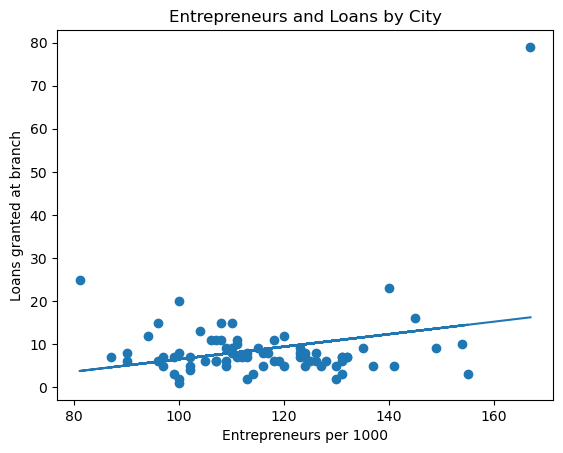

In [38]:
y_predict = model_ent.predict(X)
coef_determination = r2_score(y_true=y, y_pred=y_predict)

print(f"{model_ent.coef_[0] = }")
print(f"{model_ent.intercept_ = }")
print(f"Model accuracy: {coef_determination}")

fig, ax = plt.subplots()

ax.scatter(x, y)
ax.set_title("Entrepreneurs and Loans by City")
ax.set_xlabel("Entrepreneurs per 1000")
ax.set_ylabel("Loans granted at branch")

ax.plot(x, y_predict)

plt.show()

In [39]:
# https://en.wikipedia.org/wiki/London
dfe.sort_values(by="cityLoans", axis=0, ascending=False).head()

,cityID,entrepeneurs,cityName,inhabitants,cityLoans
0,1,167,London,1204953,79
69,70,81,Glasgow,285387,25
53,54,140,Birmingham,387570,23
73,74,100,Manchester,323870,20
63,64,145,Liverpool,197099,16


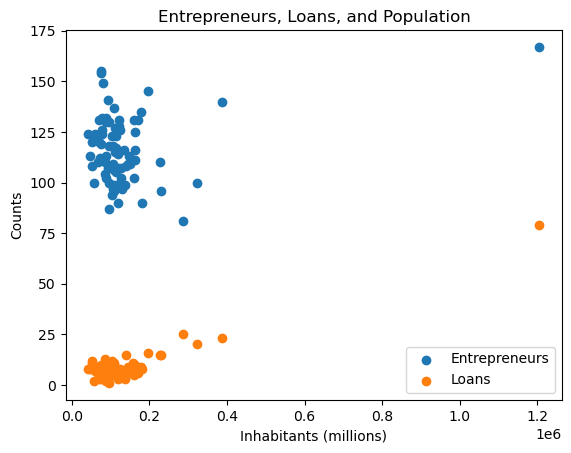

In [127]:
fig, ax = plt.subplots()

# it's probably with income or something

ax.scatter(dfe["inhabitants"], x, label="Entrepreneurs")
ax.scatter(dfe["inhabitants"], dfe["cityLoans"], label="Loans")

ax.set_title("Entrepreneurs, Loans, and Population")
ax.set_xlabel("Inhabitants (millions)")
ax.set_ylabel("Counts")
ax.legend()

plt.show()

## Task 4: Experimental Results and Analysis (25 Marks)

Given the **five** modelling solutions implemented above, analyse, discuss and present your findings to the key stakeholders of the bank.

Your answer should clearly cover the following:
* Present your findings in a clear and concise manner;
* Discuss your results in the context of the selected solution;
* Discuss how these results can help the bank in performing customer risk assessment and establishing customer retention strategies;
* Present the limitations (if any) of your solutions in a clear and concise manner.

**World Limit**: 500 words. This limit applies only to the explanations. There is no limit on any associated code or figures.

**Write your answer here (text cell(s) to be used, as appropriate)**

<img src="think.jpg" alt="PowerPoint®" width=100>

We begin with demographic analysis. Observing the figure "Clients by age", you can see a distribution close to what we might expect from the nationwide age profile[^1]. There is a mismatch in the higher age range, which is somewhat expected as older people may predate current banking systems, and may have their personal finances managed by relatives. However, it could hint at a lack of customer retention over the long term. The underrepresentation in the lowest age range is also expected, as a toddler wouldn't have a bank account, but including clients up to 21 years old this is disappointing. Your "junior" credit card offering may be underperforming, and you may want to look into benefits and discount schemes for student current accounts.

In the next figure, "Clients by generation", the underrepresentation in the milennial demographic is even more clear. Moving on, we segmented customer activity by the same demographic age ranges. In the "Greatest Generation" born before 1928, we see a lower overall proportion of activity, and an even lower proportion of credit card ownership and standing orders. See above for reasoning. The "Silent Generation" demographic is fairly even. Among the "Baby Boomers" there is a high proprotion of borrowing with loans, which I would attribute to a boom in home ownership. In the two youngest generations, credit card usage is highest, probably due to financial crashes and difficulty making ends meet.

Looking at the region visualisation in figures "Clients and activity by region" and "Mean age by region", we see credit card ownership overrepresented in Greater London, West Yorkshire, and Essex, and underrepresented in the West Midlands. This could related to cost of living, and we could market more aggressively to these regions. Loans are high in Devon.

The loan prediction model is one of the most successful parts of the projet in my opinion - we collated data on loans that have and have not been paid back by loan amount and duration, age of the client and their account, and a variety of statistics about their home city. Omitting the city itself from the model and just using the demographics allows us to continue to use and adapt this model as the demographics in individual cities shift. The model shows a success rate of upwards of 80% at predicting whether a loan will be successfully paid back or not. You could use this for customer-facing interfaces to give suggestions what will and won't be granted without spending associate time, and for streamlining the administrative process. We must remember the limitation of the model though, it will not be 100% accurate, there will be false negative and positives and we don't want to create a self-fulfilling cycle.

Next we performed a statistical test on how credit card ownership affected customer retention. We measured when clients stopped making transactions to estimate this. We found tenuous connections, with the statistical significants being below 0.25% threshold for a two-tailed test in both cases, meaning we checked for increased and decreased retention. Classic card holders had slightly lower but very close tenures with us than average. Gold holders had an increase, and to a more significant degree, but still not significant enough to act on. The sample size was also small, and this was predicatable as the causation is probably that the most loyal customers get Gold cards. You could look into reducing interest to increase retention of Classic customers.

Finally, we hypothesised a connection between entrepreneurship and loan taking, as people would take out loans to start businesses. This also proved unproductive, as the correllation was less than 0.06 out of 1, (Figure "entrepreneurs and loans by city") and there is a closer connection between both of these factors and population ("Entrepreneurs, Loans, and Population"). The outlier is unsurprisingly London, the capital city.

[^1]: https://www.gov.uk/government/statistics/population-statistics-for-rural-england/b-population-age-profilen

In [ ]:
### Write your answer here (code cell(s) to be used, as appropriate)


----
----

## Task 5: Conclusion (10 Marks)

Given the insights derived from Tasks 1-4, provide a conclusion that clearly covers the following:
* A summary of the main points;
* A discussion of the significance of your results;
* Any recommendation(s) resulting from your analysis;
* Any overall ethical considerations arising from the data analysis of this business domain.

**World Limit**: 300 words.

**Write your answer here (text cell(s) to be used, as appropriate)**


In [ ]:
### Write your answer here (code cell(s) to be used, as appropriate)


----
----

## Overall Academic Quality (10 Marks)
10 marks are allocated for the clarity and cohesiveness of your answers (both text and code) across all tasks with appropriate, relevant and effective analysis and presentation of the results.

## Deliverables

You should submit the following to the submission point on the teaching portal:

1. the SQLite database produced in Task 2;
2. the completed Jupyter notebook (both .ipynb and HTML files) that also includes the SQL statements (Task 2), the research design and its implementation (Task 3), and the analysis and presentation of your results (Task 4);
3. any figures or diagrams that are included in your answers in the Jupyter notebook.

For each task where text is required, we have provided guidelines above on the suggested word counts. Exceeding the word count will result in any work beyond the word count being disregarded when assessing.